In [58]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from Bio import pairwise2

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, KFold, RandomizedSearchCV
#from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import r2_score, mean_squared_error
#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Embedding
#from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv('datasets/yuanli-trans-splicing-1332.csv')
data['fluo'] = data[['fluo1', 'fluo2', 'fluo3']].median(axis=1) #use mean or median

In [ ]:
prefix = data['rna5'].loc[0][:577]
data['rna5'].apply(lambda x: x.startswith(prefix)).sum(), len(data)

In [ ]:
prefix2 = data['rna5'].loc[0][-49:]
data['rna5'].apply(lambda x: x.endswith(prefix2)).sum(), len(data)

In [ ]:
suffix = data['rna3'].loc[0][:68]
data['rna3'].apply(lambda x: x.startswith(suffix)).sum(), len(data)

In [ ]:
suffix2 = data['rna3'].loc[0][-732:]
data['rna3'].apply(lambda x: x.endswith(suffix2)).sum(), len(data)

In [3]:
data['rna5'] = data['rna5'].apply(lambda x: x[577:-49])
data['rna3'] = data['rna3'].apply(lambda x: x[68:-732])
data['fluo_log'] = np.log10(data['fluo'])

In [133]:
data['rna5_rna3'] = data['rna5'] + data['rna3']
data['rna5_rna3'].nunique()

1332

In [132]:
data['rna3'].nunique()

36

### Feature Extraction

K-mers only

In [178]:
target = 'fluo'
y = data[target]

In [179]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence)-size+1)]

kmers = [3, 4, 5, 6]
X_kmers = pd.DataFrame()
for k in kmers:
    words5 = data['rna5'].apply(lambda x: getKmers(str(x), k))
    words3 = data['rna3'].apply(lambda x: getKmers(str(x), k))
    texts = list(words5 + words3)
    for item in range(len(texts)):
        texts[item] = ' '.join(texts[item])
        
    cv = CountVectorizer()
    features = pd.DataFrame(cv.fit_transform(texts).toarray())
    X_kmers = pd.concat([X_kmers, features], axis=1)

In [180]:
X = X_kmers.copy()

In [181]:
X_cv = X.copy()
X_cv['target'] = y

In [182]:
kf = KFold(n_splits=5, shuffle=True)
r2_scores = []
y_tests = []
y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = MLPRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    y_tests.extend(y_test.tolist())
    y_preds.extend(y_pred.tolist())

5it [00:10,  2.10s/it]


In [183]:
np.std(r2_scores)

0.1033815661486029

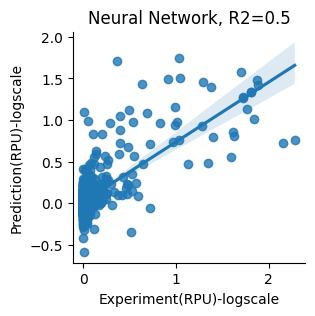

In [184]:
plt.figure(figsize=[3, 3])
sns.regplot(y_tests, y_preds)
plt.title('Neural Network, R2={}'.format(np.round(r2_score(y_tests, y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [185]:
kf = KFold(n_splits=5, shuffle=True)
rf_r2_scores = []
rf_y_tests = []
rf_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = RandomForestRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    rf_r2_scores.append(r2_score(y_test, y_pred))
    rf_y_tests.extend(y_test.tolist())
    rf_y_preds.extend(y_pred.tolist())

5it [00:43,  8.68s/it]


In [186]:
np.std(rf_r2_scores)

0.14383040118793

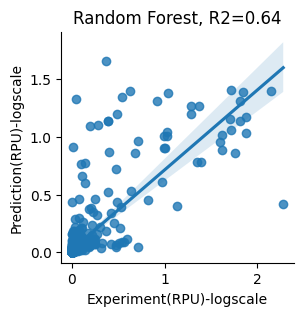

In [187]:
plt.figure(figsize=[3, 3])
sns.regplot(rf_y_tests, rf_y_preds)
plt.title('Random Forest, R2={}'.format(np.round(r2_score(rf_y_tests, rf_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [170]:
kf = KFold(n_splits=5, shuffle=True)
gb_r2_scores = []
gb_y_tests = []
gb_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = GradientBoostingRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    gb_r2_scores.append(r2_score(y_test, y_pred))
    gb_y_tests.extend(y_test.tolist())
    gb_y_preds.extend(y_pred.tolist())

5it [00:11,  2.31s/it]


In [171]:
np.std(gb_r2_scores)

0.01577400501785022

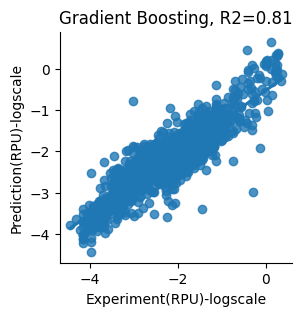

In [119]:
plt.figure(figsize=[3, 3])
sns.regplot(gb_y_tests, gb_y_preds)
plt.title('Gradient Boosting, R2={}'.format(np.round(r2_score(gb_y_tests, gb_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [124]:
kf = KFold(n_splits=5, shuffle=True)
gp_r2_scores = []
gp_y_tests = []
gp_y_preds = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    #print(train_index, test_index)
    X_train = X_cv.loc[train_index].drop('target', axis=1).values
    X_test = X_cv.loc[test_index].drop('target', axis=1).values
    y_train = X_cv.loc[train_index]['target'].values
    y_test = X_cv.loc[test_index]['target'].values
    
    estimator = gp.GaussianProcessRegressor()
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    gp_r2_scores.append(r2_score(y_test, y_pred))
    gp_y_tests.extend(y_test.tolist())
    gp_y_preds.extend(y_pred.tolist())

5it [00:11,  2.32s/it]


In [122]:
np.std(gp_r2_scores)

0.3095826260655497

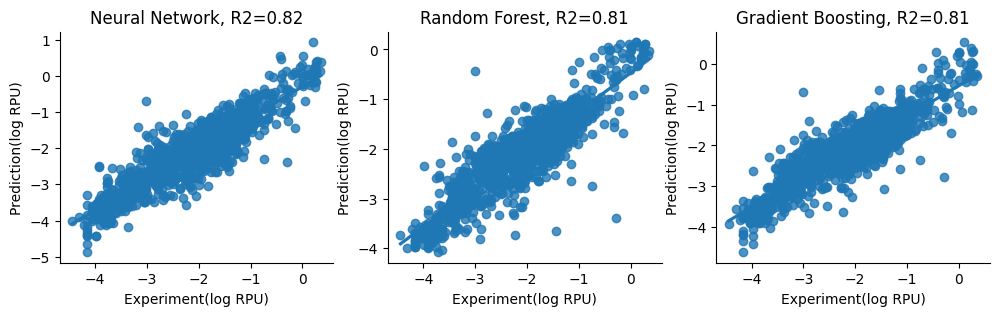

In [172]:
f, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(12, 3))
axr = axs.ravel()

sns.regplot(y_tests, y_preds, ax=axr[0])
axr[0].set_title('Neural Network, R2={}'.format(np.round(r2_score(y_tests, y_preds), 2)))
axr[0].set_xlabel('Experiment(log RPU)')
axr[0].set_ylabel('Prediction(log RPU)')
sns.despine()

sns.regplot(rf_y_tests, rf_y_preds, ax=axr[1])
axr[1].set_title('Random Forest, R2={}'.format(np.round(r2_score(rf_y_tests, rf_y_preds), 2)))
axr[1].set_xlabel('Experiment(log RPU)')
axr[1].set_ylabel('Prediction(log RPU)')
sns.despine()

sns.regplot(gb_y_tests, gb_y_preds, ax=axr[2])
axr[2].set_title('Gradient Boosting, R2={}'.format(np.round(r2_score(gb_y_tests, gb_y_preds), 2)))
axr[2].set_xlabel('Experiment(log RPU)')
axr[2].set_ylabel('Prediction(log RPU)')
sns.despine()

In [173]:
nn = pd.DataFrame([y_tests, y_preds]).T
rf = pd.DataFrame([rf_y_tests, rf_y_preds]).T
gb = pd.DataFrame([gb_y_tests, gb_y_preds]).T
df = pd.concat([nn, rf, gb], axis=1)
df.columns = ['neural-network-exp', 'neural-network-pred', 'random-forest-exp', 'random-forest-pred', 'gradient-boosting-exp', 'gradient-boosting-pred']

In [176]:
(10**df).to_csv('datasets/trans-splicing-prediction-linearscale.csv', index=False)

[]

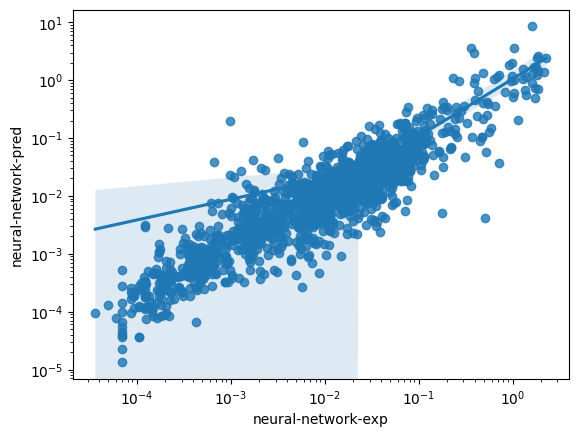

In [188]:
sns.regplot(10**df['neural-network-exp'], 10**df['neural-network-pred'])
r2_score(10**df['neural-network-exp'], 10**df['neural-network-pred'])
plt.loglog()

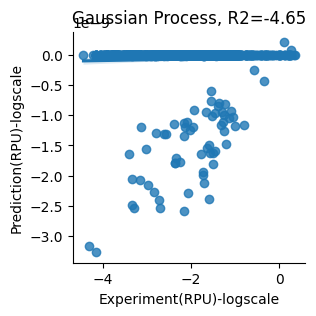

In [123]:
plt.figure(figsize=[3, 3])
sns.regplot(gp_y_tests, gp_y_preds)
plt.title('Gaussian Process, R2={}'.format(np.round(r2_score(gp_y_tests, gp_y_preds), 2)))
plt.xlabel('Experiment(RPU)-logscale')
plt.ylabel('Prediction(RPU)-logscale')
sns.despine()

In [54]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR#, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

regressors = [
    #KNeighborsRegressor(3),
    #SVR(kernel="rbf", C=0.025),
    #NuSVC(probability=True),
    #DecisionTreeRegressor(),
    RandomForestRegressor(),
    #AdaBoostRegressor(),
    GradientBoostingRegressor(),
    MLPRegressor()
    ]
for regressor in regressors:
    
    pipe = Pipeline(steps=[#('preprocessor', preprocessor),
                      ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    print("model score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor()
model score: 0.809
GradientBoostingRegressor()
model score: 0.812
MLPRegressor()
model score: 0.801


In [61]:
estimator = MLPRegressor()
prediction = cross_val_predict(estimator, X, y, cv=5)

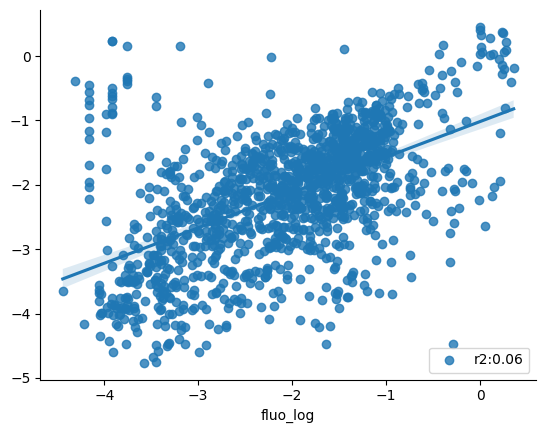

In [62]:
r = r2_score(y, prediction)
sns.regplot(y, prediction, label='r2:{}'.format(np.round(r, 2)))
plt.legend()
sns.despine()

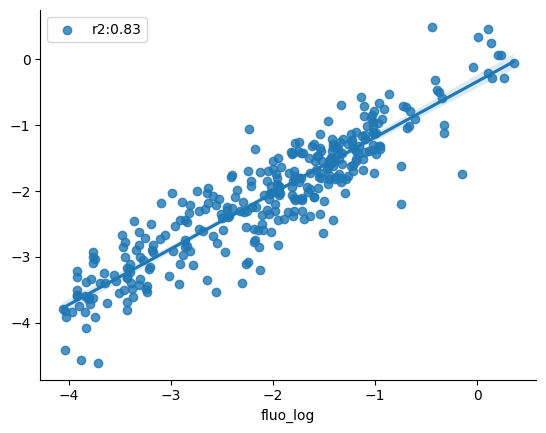

In [52]:
y_pred = regr.predict(X_test)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='r2:{}'.format(np.round(r, 2)))
plt.legend()
sns.despine()

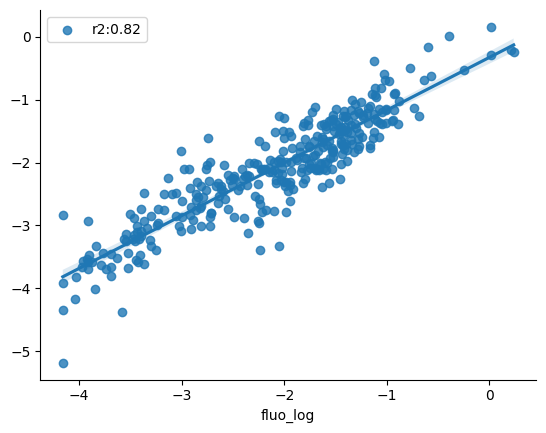

In [44]:
y_pred = regr.predict(X_test)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='r2:{}'.format(np.round(r, 2)))
plt.legend()
sns.despine()

In [27]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,707,708,709,710,711,712,713,714,715,716
487,1,1,1,0,3,1,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
260,2,2,0,0,0,1,1,0,0,3,...,0,0,1,0,0,0,0,0,0,0
831,1,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
969,2,1,3,0,1,0,3,0,0,2,...,0,0,0,0,0,0,0,0,0,0
714,2,1,1,0,0,0,2,0,0,2,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,2,2,3,0,0,1,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
901,1,0,0,0,1,0,3,0,0,1,...,0,0,0,0,0,0,1,1,0,0
109,2,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
704,1,1,1,0,0,0,2,0,0,2,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
from functools import lru_cache

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    
    params:
        a (String) : The first string you want to compare
        b (String) : The second string you want to compare
        
    returns:
        This function will return the distnace between string a and b.
        
    example:
        a = 'stamp'
        b = 'stomp'
        lev_dist(a,b)
        >> 1.0
    '''
    
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

lev_dist(data['rna5'].loc[0], data['rna3'].loc[0])

In [ ]:
scores = []
for i in range(len(data)):
    score = pairwise2.align.globalxx(data['rna5'].iloc[i], data['rna3'].iloc[i], score_only=True)
    if not isinstance(score, float):
        score = np.mean(score)
    scores.append(score)
data['alignment_score'] = scores

In [ ]:
scores = []
for i in range(len(data)):
    score = lev_dist(data['rna5'].iloc[i], data['rna3'].iloc[i])
    #if not isinstance(score, float):
    #    score = np.mean(score)
    scores.append(score)
data['lev_distance'] = scores

In [ ]:
X = pd.concat([X, kmers_features], axis=1)
X

In [ ]:
df = pd.DataFrame(X)
df['score'] = data['alignment_score']
df['distance'] = data['lev_distance']
X = df.fillna(0).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#regr = gp.GaussianProcessRegressor()
#regr = RandomForestRegressor()
regr = MLPRegressor()
regr.fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test)
mape = 100 - mean_absolute_percentage_error(y_test, y_pred)
r = r2_score(y_test, y_pred)
sns.regplot(y_test, y_pred, label='r2:{}'.format(np.round(r, 2)))
plt.legend()
sns.despine()

In [ ]:
sns.regplot(data['alignment_score'], data['fluo'])